In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

## A simple physics model

Suppose we want to simulate the motion of a ball. More specifically, for each time $t$, we would like to know the position, $\vec{x}$ of an object, perhaps under some acceleration $\vec{a}$.

Kinematic equations tell us:
\begin{equation}
\vec{x}(t) = \vec{x}_{0} + \vec{v}_{0}t + \frac{1}{2}\vec{a}t^2
\end{equation}

where $\vec{x}_{0}$ and $\vec{v}_{0}$ are the initial position/velocity.

In code: 

In [2]:
def position(t, a, x0, v0):
    return x0 + v0*t + 0.5*a*t**2

Sticking to 2d for visualization purposes, we can run a simple simulation to get the trajectory of an object under the influence of gravity, namely:

$\vec{a}$ = (0, -9.8), in units of $m / s^2$

In [3]:
#Acceleration due to gravity (-9.8 m/s^2 in negative y direction)
a = np.asarray([0, -9.8])

#Initial velocity for fun (m / s)
v0 = np.asarray([5, 10])

#Start at (0,10) [m]
x0 = np.asarray([0,10])

We then can create a trajectory for the object by "measuring" position at a set of time steps

In [4]:
#Run the simulation: 100 timesteps
time_steps = np.linspace(0, 5, 100)

trajectory = []
for t_step in time_steps:
    xt = position(t_step, a, x0, v0)
    trajectory.append(xt)
    
trajectory = np.asarray(trajectory)

For fun, let's animate how this might look:

In [5]:
xlim = [trajectory[:, 0].min(), trajectory[:, 0].max()]
ylim = [trajectory[:, 1].min(), trajectory[:, 1].max()]

<IPython.core.display.Javascript object>


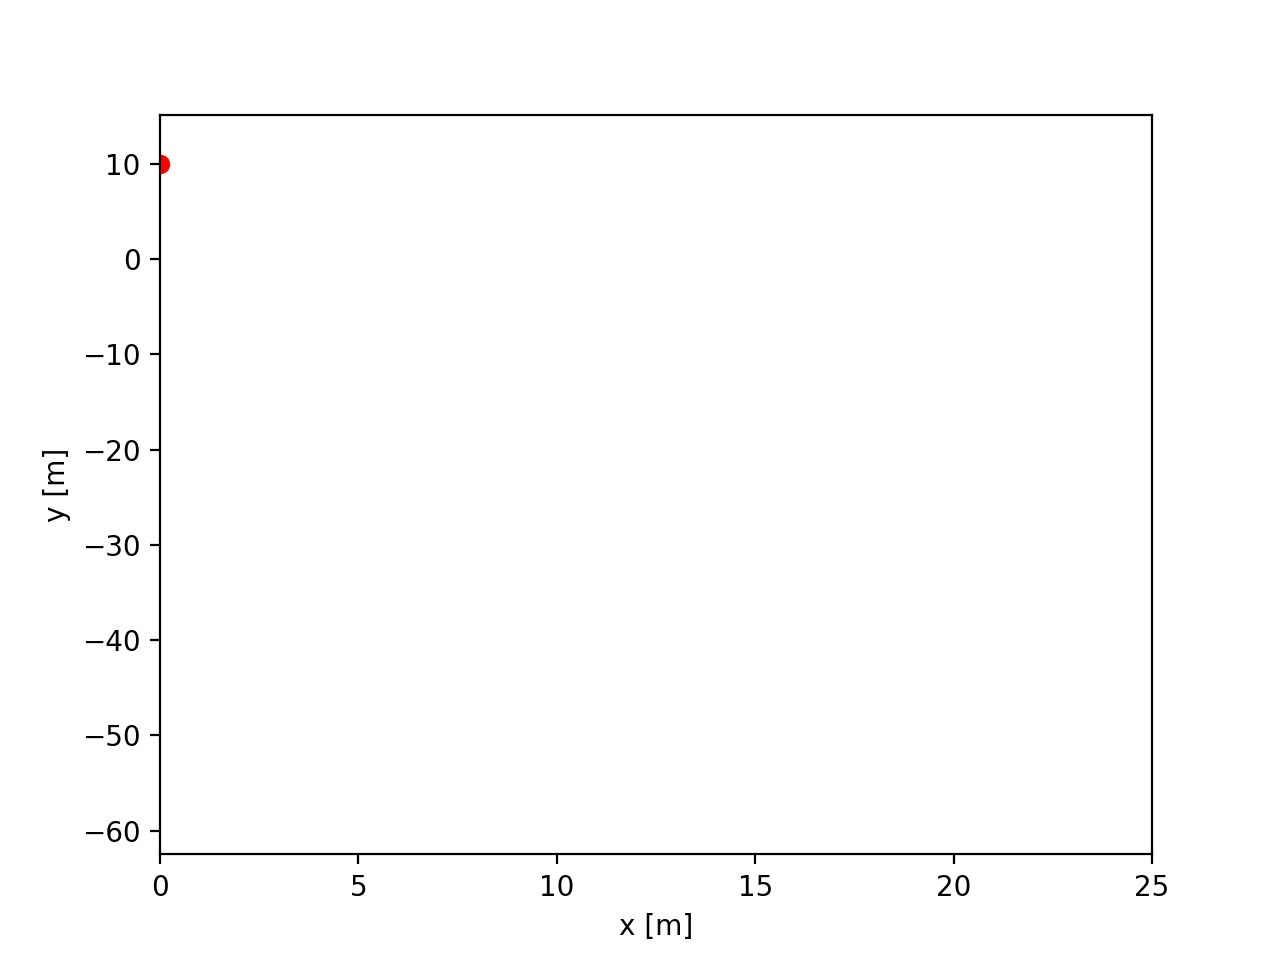

In [7]:
%matplotlib notebook

fig, ax = plt.subplots()

dot, = ax.plot([x0[0]], [x0[1]], 'ro')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

def animate(time_step):
    dot.set_data(trajectory[time_step, 0], trajectory[time_step, 1])
    return dot,

anim = FuncAnimation(fig, animate, frames=len(time_steps), interval=25, repeat=True, blit=True)
plt.show()

Or, just plotting all time steps:

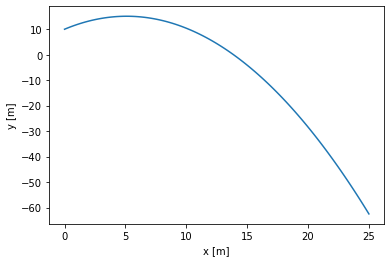

In [8]:
%matplotlib inline
plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

We now have a physics simulator (albeit a simple one)! 

### Terminology: 
In the ML context, we call the above simulator our **forward model**, namely: we start from some set of conditions, and we use the forward model to get some result.

### Today: 
Imagine we know the forward model, and we have some dataset. In a real context, this could correspond to experimental data, where the forward model is the physics simulation. How can we use the forward model to gain insight into the experimental data? More particularly, can we use the forward model to extract physical parameters from the real dataset? This is where differentiable simulation can be useful! Notable examples: detector calibration, physics reconstruction.

### In our case:
Suppose we're given some kinematic trajectory, but we don't know the initial velocity? Or the acceleration? Or the initial position? A differentiable kinematics simulator provides an easy tool to extract these parameters. Let's see how this works.

## Step 1: Differentiable forward model

We'll use PyTorch here, but the same concepts apply to any framework

In [9]:
import torch

### Convenience step: Vectorization
In principle, for loops are ok! In practice, it's often more convenient to repackage.

Our data: single 2D kinematic trajectory with measurements at `n_steps` time steps $\implies$ the output of the simulation should have shape `(n_steps, 2)`.

In [10]:
trajectory.shape

(100, 2)

Repeating here for clarity, but: position function can stay the same!

In [11]:
def position(t, a, x0, v0):
    return x0 + v0*t + 0.5*a*t**2

However, we need to adjust the shapes to work.

Think of time as the zeroth dimension, spatial coordinates as the first dimension. Then, if we define our parameters as:

In [12]:
#Acceleration due to gravity (-9.8 m/s^2 in negative y direction)
a = torch.tensor([0, -9.8])[None, :]

#Initial velocity for fun (m / s)
v0 = torch.tensor([5, 10])[None, :]

#Start at (0,10) [m]
x0 = torch.tensor([0,10])[None, :]

In [13]:
a.shape

torch.Size([1, 2])

and our timesteps as:

In [14]:
#Run the simulation: 100 timesteps
time_steps = torch.linspace(0, 5, 100)[:, None]

In [15]:
time_steps.shape

torch.Size([100, 1])

Broadcasting will then give us the desired shape

In [16]:
trajectory = position(time_steps, a, x0, v0)

In [17]:
print(trajectory.shape)

torch.Size([100, 2])


and we haven't changed any values, so the output should be identical

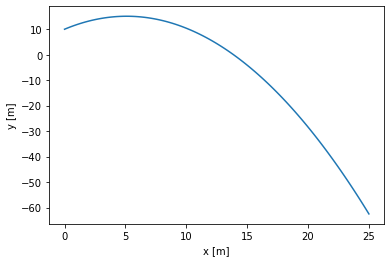

In [18]:
%matplotlib inline
plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

### Summary: 

Things are easy for us today! Our forward model is a single function, `position`, which takes in measurement times, acceleration, initial position, and initial velocity, and returns a trajectory ($x$ and $y$ positions at each time step).

Note that this is trivially differentiable -- we only use addition and multiplication! A more complicated simulation might require more tricks, but let's leave that for another day

## Step 2: "Take" some data

For today, we'll be using a single trajectory with some given parameter values as our target. This is the most perfect case -- our forward model is exact and we know the true parameter values. Real life is more complicated, but everybody starts somewhere!

Let's use the same trajectory as above, but recording for posterity:

In [19]:
#Acceleration due to gravity (-9.8 m/s^2 in negative y direction)
a_target = torch.tensor([0, -9.8])[None, :]

#Initial velocity for fun (m / s)
v0_target = torch.tensor([5, 10])[None, :]

#Start at (0,10) [m]
x0_target = torch.tensor([0,10])[None, :]

#Data taken at 100 known timesteps from 0 to 5 s
time_steps = torch.linspace(0, 5, 100)[:, None]

Target is the corresponding trajectory

In [20]:
trajectory_target = position(time_steps, a_target, x0_target, v0_target)

## Step 3: Set up parameter gradients

To start, let's try to solve for the initial velocity. We need to set up a new forward model with an initial guess. We can then iterate over the new model parameters.


We assume only v0 changes for now, so everything else is the same

In [21]:
#Acceleration due to gravity (-9.8 m/s^2 in negative y direction)
a_guess = torch.tensor([0, -9.8])[None, :]

#Start at (0,10) [m]
x0_guess = torch.tensor([0.,10.])[None, :]

#Run the simulation: 100 timesteps
time_steps = torch.linspace(0, 5, 100)[:, None]

And we don't know v0, so let's initialize to (0, 0)

In [22]:
#Initial velocity for fun (m / s)
v0_guess = torch.tensor([0., 0.])[None, :]

Now we need a training loop. There are two important pieces:

1. A **loss function**: in this case the easiest is just the Mean Squared Error between the output of the "guess" forward model and the target trajectory.

2. An **optimizer**: how do we change parameters to try to fit the trajectory? Let's start with a simple gradient descent.

Recall that gradient descent for some parameter (or vector of parameters) $\theta$ at training step $i$ has update rule:

\begin{equation}
\theta_{i+1} = \theta_{i} - \eta\cdot\nabla_{\theta}f(\theta_i)
\end{equation}

where $f$ is our objective function, and $\eta$ is a _learning rate_ which controls the size of the gradient step. 

To do gradient descent, we need to keep track of gradients. In PyTorch this is done with setting `requires_grad = True` for the relevant parameters, either as an argument to `torch.tensor` in the initialization, or after the fact, like:

In [23]:
v0_guess.requires_grad = True

Gradients of `v0_guess` are accessible via the attribute `v0_guess.grad`. Right now, `v0_guess` hasn't interacted with the physics model, so this is not filled.

In [24]:
print(v0_guess.grad)

None


## The training loop

There are a few steps in the typical autodiff training loop. First, we need to initialize the parameters we want to fit -- we already did this above, but just to keep everything together, let's repeat.

### Fixed parameters:

In [25]:
#Acceleration due to gravity (-9.8 m/s^2 in negative y direction)
a_guess = torch.tensor([0, -9.8])[None, :]

#Start at (0,10) [m]
x0_guess = torch.tensor([0.,10.])[None, :]

#Run the simulation: 100 timesteps
time_steps = torch.linspace(0, 5, 100)[:, None]

### Not fixed parameters:
We want to solve for `v0_guess`

In [26]:
#Initial velocity for fun (m / s)
v0_guess = torch.tensor([0., 0.])[None, :]
v0_guess.requires_grad = True

Then we make a guess with the initial parameters. This is done with a simple pass through the forward model

In [27]:
trajectory_guess = position(time_steps, a_guess, x0_guess, v0_guess)

Then compute the loss between the guessed trajectory and the target

In [28]:
loss = ((trajectory_target - trajectory_guess)**2).mean()

and let PyTorch accumulate gradients with a backward pass. Note that the backward pass starts at the loss calculation -- this is the thing we want to minimize with gradient descent.

In [29]:
loss.backward()

`v0_guess` now has an associated gradient

In [30]:
print(v0_guess.grad)

tensor([[-41.8771, -83.7542]])


and we expect a velocity of order 10, so let's define a learning rate so that our updates are of appropriate size

In [31]:
lr = 0.1

This allows us to actually do the update of `v0_guess`. We don't want to keep track of gradients through this update, so we wrap this in a `with torch.no_grad()`

In [32]:
with torch.no_grad():
    v0_guess -= lr*v0_guess.grad

`v0_guess` now has an updated value, so we can repeat

In [33]:
print(v0_guess)

tensor([[4.1877, 8.3754]], requires_grad=True)


In a loop:

In [34]:
# Initialize training parameters
v0_guess = torch.tensor([0., 0.])[None, :]
v0_guess.requires_grad = True

# Learning rate -- controls the size of the optimization step
lr = 0.1

# Keep track of training and losses 
training_path = []
losses = []

# Do 10 parameter updates
for epoch in range(10):  
    # Guess with current parameters
    trajectory_guess = position(time_steps, a_guess, x0_guess, v0_guess)
    
    # Calculate loss
    loss = ((trajectory_target - trajectory_guess)**2).mean()
    
    # Compute gradients
    loss.backward()

    # Update for next loop
    with torch.no_grad():
        v0_guess -= lr*v0_guess.grad
        
    print(f"Iter {epoch}, Loss: {loss.detach().item()}")
    training_path.append(trajectory_guess.detach())
    losses.append(loss.detach())

Iter 0, Loss: 523.4638061523438
Iter 1, Loss: 13.815546989440918
Iter 2, Loss: 344.420166015625
Iter 3, Loss: 639.60791015625
Iter 4, Loss: 117.5174789428711
Iter 5, Loss: 161.00543212890625
Iter 6, Loss: 654.8856201171875
Iter 7, Loss: 291.0216979980469
Iter 8, Loss: 33.176998138427734
Iter 9, Loss: 564.3025512695312


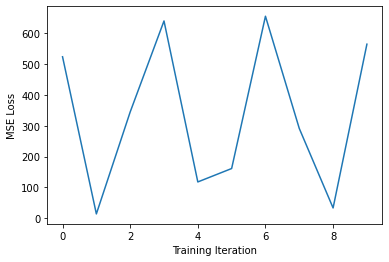

In [35]:
plt.plot(losses)
plt.xlabel('Training Iteration')
plt.ylabel('MSE Loss')
plt.show()

### Uh oh! Something went wrong! The loss should be going down!

But not really -- PyTorch requires you to zero out the gradients after each update, otherwise they accumulate (get summed). This is easily done with:

In [36]:
v0_guess.grad.zero_()

tensor([[0., 0.]])

so that the gradient stored in `v0_guess.grad` corresponds only to each individual forward/backward pass. In the loop, this should be done after every update -- something simple, but a common "first look at autograd" bug!

The proper training loop is then:

In [37]:
# Initialize training parameters
v0_guess = torch.tensor([0., 0.])[None, :]
v0_guess.requires_grad = True

# Learning rate -- controls the size of the optimization step
lr = 0.1

# Keep track of training and losses 
v0_steps = [v0_guess.detach().clone()]
training_path = []
losses = []

# Do 10 parameter updates
for epoch in range(10):   
    # Guess with current parameters
    trajectory_guess = position(time_steps, a_guess, x0_guess, v0_guess)
    
    # Calculate loss
    loss = ((trajectory_target - trajectory_guess)**2).mean()
    
    # Compute gradients
    loss.backward()

    print(f"Iter {epoch}, Loss: {loss.detach().item()}")
    
    # Update for next loop
    with torch.no_grad():
        v0_guess -= lr*v0_guess.grad
        
    # Zero out the gradients
    v0_guess.grad.zero_()

    # Store training history.
    training_path.append(trajectory_guess.detach())
    losses.append(loss.detach())
    v0_steps.append(v0_guess.detach().clone())

Iter 0, Loss: 523.4638061523438
Iter 1, Loss: 13.815546989440918
Iter 2, Loss: 0.3646274507045746
Iter 3, Loss: 0.009623614139854908
Iter 4, Loss: 0.000253990845521912
Iter 5, Loss: 6.7079008658765815e-06
Iter 6, Loss: 1.7731480284055579e-07
Iter 7, Loss: 4.59264404284454e-09
Iter 8, Loss: 1.1887828221812669e-10
Iter 9, Loss: 5.791176566072309e-12


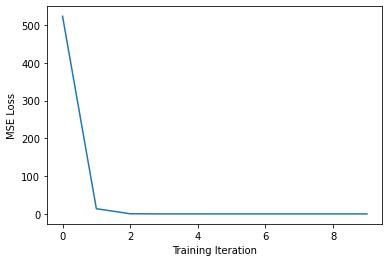

In [38]:
plt.plot(losses)
plt.xlabel('Training Iteration')
plt.ylabel('MSE Loss')
plt.show()

Converges quickly (and looks much healthier)!

Let's look quickly at the training path:

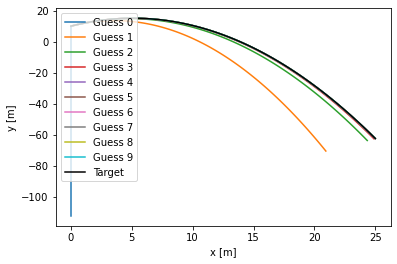

In [39]:
%matplotlib inline
for step, traj in enumerate(training_path):
    plt.plot(traj[:, 0], traj[:, 1], label=f'Guess {step}')
plt.plot(trajectory_target[:, 0], trajectory_target[:, 1], c='k', label='Target')
plt.legend(loc='upper left')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

As expected from the loss, we get closer to the target trajectory with each iteration. Looking at the values of v0:

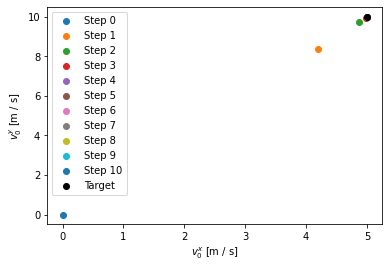

In [40]:
for i_step, step in enumerate(v0_steps):
    plt.scatter(step[:, 0], step[:, 1], label=f'Step {i_step}')
plt.scatter(5, 10, c='k', label='Target')
plt.legend(loc='upper left')
plt.xlabel('$v_{0}^{x}$ [m / s]')
plt.ylabel('$v_{0}^{y}$ [m / s]')
plt.show()

In [41]:
v0_steps[-1]

tensor([[ 5., 10.]])

we recover the target parameters.

## Slightly more complicated -- more parameters!

### Exercise:

Let's go crazy and try to fit all parameters: a, x0, and v0. The training loop is basically the same (with a couple of tweaks), just with more things, skeleton provided below:

In [40]:
# Initialize training parameters. This time we want gradients for a, x0, and v0
# Fill in here -- feel free to init to [0, 0]
v0_guess = torch.tensor([0., 0.])[None, :]

# Fill in here
v0_guess.requires_grad = True

# Learning rate -- controls the size of the optimization step
# note, we've decreased it to 0.01 -- more on that in a bit!
lr = 0.01

# Keep track of training and losses 
training_path = []
losses = []

# Do 10000 parameter updates -- do a progress bar to decrease verbosity
# Note that longer training time is needed because we have a smaller learning rate
for epoch in tqdm(range(10000)):  
    # Guess with current parameters
    trajectory_guess = position(time_steps, a_guess, x0_guess, v0_guess)
    
    # Calculate loss
    loss = ((trajectory_target - trajectory_guess)**2).mean()
    
    # Compute gradients
    loss.backward()

    #print(f"Iter {epoch}, Loss: {loss.detach().item()}")
    
    # Update for next loop -- simultaneous update of all three
    with torch.no_grad():
        v0_guess -= lr*v0_guess.grad
        # Fill in here: update x0_guess and a_guess with gradient descent

    # Zero out the gradients
    v0_guess.grad.zero_()
    # Fill in here: need to zero out gradients for x0_guess and a_guess too


    # Store training history.
    training_path.append(trajectory_guess.detach())
    losses.append(loss.detach())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5645.80it/s]


### Answer:

In [43]:
# Initialize training parameters. This time we want gradients for a, x0, and v0
a_guess = torch.tensor([0., 0.])[None, :]
x0_guess = torch.tensor([0.,0.])[None, :]
v0_guess = torch.tensor([0., 0.])[None, :]

a_guess.requires_grad = True
x0_guess.requires_grad = True
v0_guess.requires_grad = True

# Learning rate -- controls the size of the optimization step
lr = 0.01

# Keep track of training and losses 
training_path = []
losses = []

# Do 10000 parameter updates -- do a progress bar to decrease verbosity
for epoch in tqdm(range(10000)):  
    # Guess with current parameters
    trajectory_guess = position(time_steps, a_guess, x0_guess, v0_guess)
    
    # Calculate loss
    loss = ((trajectory_target - trajectory_guess)**2).mean()
    
    # Compute gradients
    loss.backward()

    #print(f"Iter {epoch}, Loss: {loss.detach().item()}")
    
    # Update for next loop -- simultaneous update of all three
    with torch.no_grad():
        v0_guess -= lr*v0_guess.grad
        x0_guess -= lr*x0_guess.grad
        a_guess -= lr*a_guess.grad

    # Zero out the gradients
    v0_guess.grad.zero_()
    x0_guess.grad.zero_()
    a_guess.grad.zero_()


    # Store training history.
    training_path.append(trajectory_guess.detach())
    losses.append(loss.detach())

100%|██████████| 10000/10000 [00:02<00:00, 4556.80it/s]


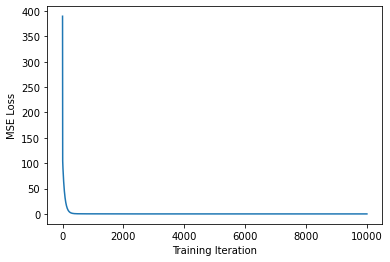

In [44]:
plt.plot(losses)
plt.xlabel('Training Iteration')
plt.ylabel('MSE Loss')
plt.show()

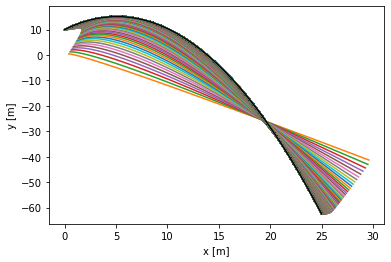

In [45]:
%matplotlib inline
for step, traj in enumerate(training_path):
    if step % 10 == 0:
        plt.plot(traj[:, 0], traj[:, 1], label=f'Guess {step}')
plt.plot(trajectory_target[:, 0], trajectory_target[:, 1], c='k', label='Target')
#plt.legend()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

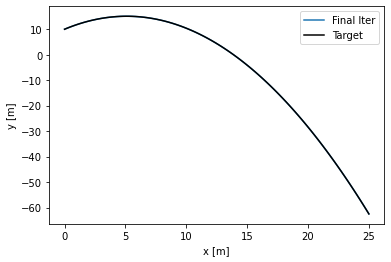

In [46]:
plt.plot(training_path[-1][:, 0], training_path[-1][:, 1], label='Final Iter')
plt.plot(trajectory_target[:, 0], trajectory_target[:, 1], c='k', label='Target')
plt.legend()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

In [47]:
print(f'Final v0: {v0_guess.detach()[0]}, Target: {v0_target[0]}')
print(f'Final x0: {x0_guess.detach()[0]}, Target: {x0_target[0]}')
print(f'Final a: {a_guess.detach()[0]}, Target: {a_target[0]}')

Final v0: tensor([4.9961, 9.9978]), Target: tensor([ 5, 10])
Final x0: tensor([4.1948e-03, 1.0002e+01]), Target: tensor([ 0, 10])
Final a: tensor([ 1.3894e-03, -9.7992e+00]), Target: tensor([ 0.0000, -9.8000])


## Learning rates and convergence

Let's try using the learning rate that we started out with. The loop:

In [48]:
# Initialize training parameters. This time we want gradients for a, x0, and v0
a_guess = torch.tensor([0., 0.])[None, :]
x0_guess = torch.tensor([0.,0.])[None, :]
v0_guess = torch.tensor([0., 0.])[None, :]

a_guess.requires_grad = True
x0_guess.requires_grad = True
v0_guess.requires_grad = True

# Learning rate -- back up to 0.1
lr = 0.1

# Keep track of training and losses 
training_path = []
losses = []

# Back to 10 updates
for epoch in range(10):   
    # Guess with current parameters
    trajectory_guess = position(time_steps, a_guess, x0_guess, v0_guess)
    
    # Calculate loss
    loss = ((trajectory_target - trajectory_guess)**2).mean()
    
    # Compute gradients
    loss.backward()

    print(f"Iter {epoch}, Loss: {loss.detach().item()}")
    
    # Update for next loop -- simultaneous update of all three
    with torch.no_grad():
        v0_guess -= lr*v0_guess.grad
        x0_guess -= lr*x0_guess.grad
        a_guess -= lr*a_guess.grad

    # Zero out the gradients
    v0_guess.grad.zero_()
    x0_guess.grad.zero_()
    a_guess.grad.zero_()


    # Store training history.
    training_path.append(trajectory_guess.detach())
    losses.append(loss.detach())

Iter 0, Loss: 389.738037109375
Iter 1, Loss: 2653.56396484375
Iter 2, Loss: 23547.765625
Iter 3, Loss: 215280.0
Iter 4, Loss: 1973733.75
Iter 5, Loss: 18100418.0
Iter 6, Loss: 165996640.0
Iter 7, Loss: 1522337536.0
Iter 8, Loss: 13961199616.0
Iter 9, Loss: 128036683776.0


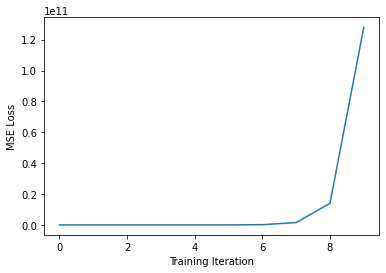

In [49]:
plt.plot(losses)
plt.xlabel('Training Iteration')
plt.ylabel('MSE Loss')
plt.show()

### Uh oh, the loss should be going down!

Usually when this happens, the learning rate is too big -- the optimization procedure doesn't converge to a minimum because we're "bouncing around" the parameter space.

#### Solutions:
1. Guess and check: try decreasing learning rate. Often helpful to look at the magnitude of the corresponding gradients to get an idea of appropriate magnitudes
2. Use a better optimizer (e.g. something adaptive like Adam)

In our case, guessing should be sufficient. Note that _decreasing_ the size of our update steps means that we should _increase_ the number of training iterations.

## Cleaning up
We've manually defined our loss function and optimizer, but using built in PyTorch stuff generalizes much better! Rewriting:

In [50]:
# Same MSE loss from PyTorch
loss_fn = torch.nn.MSELoss()

# If we want to initialize at 0's we should use torch.zeros
a_guess = torch.zeros((1, 2), requires_grad=True)
x0_guess = torch.zeros((1, 2), requires_grad=True)
v0_guess = torch.zeros((1, 2), requires_grad=True)

# Torch has a bunch of built in optimizers. Stick with gradient descent.
optimizer = torch.optim.SGD([a_guess, x0_guess, v0_guess], lr=0.01)

# Same simple history tracking
training_path = []
losses = []
for epoch in tqdm(range(10000)):
    # This line replaces the per-parameter gradient zeroing
    optimizer.zero_grad()
    
    # Forward model done the same way
    trajectory_guess = position(time_steps, a_guess, x0_guess, v0_guess)
    
    # Pass to loss function
    loss = loss_fn(trajectory_target, trajectory_guess)
    
    # Backward pass done the same way
    loss.backward()

    # The optimizer takes care of the gradient steps
    optimizer.step()
        
    losses.append(loss.detach())
    training_path.append(trajectory_guess.detach())

100%|██████████| 10000/10000 [00:02<00:00, 4096.68it/s]


Results are completely identical

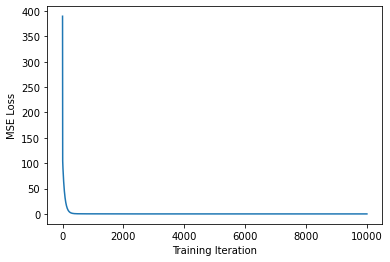

In [51]:
plt.plot(losses)
plt.xlabel('Training Iteration')
plt.ylabel('MSE Loss')
plt.show()

In [52]:
print(losses[-1])

tensor(1.4409e-06)


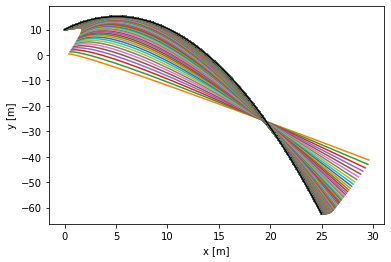

In [53]:
%matplotlib inline
for step, traj in enumerate(training_path):
    if step % 10 == 0:
        plt.plot(traj[:, 0], traj[:, 1], label=f'Guess {step}')
plt.plot(trajectory_target[:, 0], trajectory_target[:, 1], c='k', label='Target')
#plt.legend()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

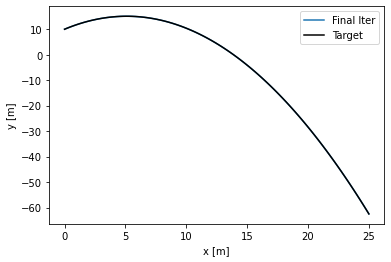

In [54]:
plt.plot(training_path[-1][:, 0], training_path[-1][:, 1], label='Final Iter')
plt.plot(trajectory_target[:, 0], trajectory_target[:, 1], c='k', label='Target')
plt.legend()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

In [55]:
print(f'Final v0: {v0_guess.detach()[0]}, Target: {v0_target[0]}')
print(f'Final x0: {x0_guess.detach()[0]}, Target: {x0_target[0]}')
print(f'Final a: {a_guess.detach()[0]}, Target: {a_target[0]}')

Final v0: tensor([4.9961, 9.9978]), Target: tensor([ 5, 10])
Final x0: tensor([4.1948e-03, 1.0002e+01]), Target: tensor([ 0, 10])
Final a: tensor([ 1.3894e-03, -9.7992e+00]), Target: tensor([ 0.0000, -9.8000])


## Conclusions:

We have constructed a simple physics model with PyTorch and used automatic differentiation to fit parameters of that model via gradient descent, given target data. The model we use here is very simple, but a very similar training loop can be used for much more complex physics models and many more parameters -- the important thing is the differentiability!


### Context:

The problem that we solved today can be viewed in two ways:
1. The forward model, $\Phi$ is a map from parameters $\theta$ to trajectories $X$. We can use automatic differentiation to invert this map: given $X$ and $\Phi$, we can reconstruct $\theta$.
2. Our initial parameters are parameters of our simulation, and are our best guesses at what the parameters are in real life. We've now been given some data that we believe obeys the physics of our model. We can then fit the model parameters to _calibrate_ the simulation to the data.

Keep these two contexts in mind for your experiments! The approach we demonstrated above works for both :)